In [1]:
import sys
sys.path.append('/Users/jiangxiaoyu/Desktop/All Projects/GPLVM_project_code/')
from modules.prepare_and_train_IGP import Multi_Variational_IGP
from modules.prepare_data import *
import yaml
import torch
import numpy as np
from torch import Tensor
from util_functions import *

In [2]:
def load_model_and_likelihoods(multi_variational_igp, filename):
    state_dicts = torch.load(filename)
    for model, state_dict in zip(multi_variational_igp.models, state_dicts['models']):
        model.load_state_dict(state_dict)
    for likelihood, state_dict in zip(multi_variational_igp.likelihoods, state_dicts['likelihoods']):
        likelihood.load_state_dict(state_dict)


## Load in model

In [3]:
with open('/Users/jiangxiaoyu/Desktop/All Projects/GPLVM_project_code/configs/train_IGP_config.yaml', 'r') as file:
    config = yaml.safe_load(file)

MultiIGP = Multi_Variational_IGP(
        num_models = config['n_outputs'],
        inducing_points = Tensor(np.linspace(config['init_inducing_input_LB'], config['init_inducing_input_UB'], config['n_inducing_input']).reshape(-1, 1)), 
        init_likelihood_raw_noise = config['init_likelihood_raw_noise']
    )

load_model_and_likelihoods(MultiIGP, config['model_and_likelihood_path'])

## Load in data

In [4]:
if config['dataset_type'] == 'synthetic_regression':
        data_inputs, data_Y_squeezed, ls_of_ls_train_input, ls_of_ls_test_input, train_sample_idx_ls, test_sample_idx_ls = prepare_synthetic_regression_data(config)

In [5]:
# The following piece of code copied from training_IGP.py file.
'''$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$'''
# The following lists consist of datasets for all outputs.
list_train_X, list_train_Y = [], [] 
list_test_X, list_test_Y = [], []

# split data_Y_squeezed into train/test part. NOTE: that's train/test target data for all outputs.
data_Y_train_squeezed = data_Y_squeezed[train_sample_idx_ls]
data_Y_test_squeezed = data_Y_squeezed[test_sample_idx_ls]

n_input_test = config['n_input'] - config['n_input_train']
##### ------------------------------------------------------------------------
for i in range(config['n_outputs']):
    # start and end for current output, idx used to pick data for only current output
    idgp_train_start = i * config['n_input_train']
    idgp_train_end = idgp_train_start + config['n_input_train']

    idgp_test_start = i * n_input_test
    idgp_test_end = idgp_test_start + n_input_test

    # training data for current output
    train_X = data_inputs[ls_of_ls_train_input[i]]
    train_Y = data_Y_train_squeezed[idgp_train_start:idgp_train_end]
    assert train_X.shape ==  train_Y.shape == torch.Size([config['n_input_train']])
    list_train_X.append(train_X)
    list_train_Y.append(train_Y)

    # testing data for current output
    test_X = data_inputs[ls_of_ls_test_input[i]]
    test_Y = data_Y_test_squeezed[idgp_test_start:idgp_test_end]
    assert test_X.shape ==  test_Y.shape == torch.Size([n_input_test])
    list_test_X.append(test_X)
    list_test_Y.append(test_Y)
'''$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$'''

'$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$'

## Testing

In [6]:
# for compute overall (all outputs) performance
train_error_square_sum = 0.
test_error_square_sum = 0.
train_error_length = 0.
test_error_length = 0.
train_nll_sum = 0.
test_nll_sum = 0.

# For visualization
n_points4visualization = 500
tensor_inputs4visualization = Tensor(np.linspace(-10, 10, n_points4visualization).reshape(-1, 1)) 
list_train_output_dist = []
list_test_output_dist = []
list_output_dist4visual = []

for j in range(config['n_outputs']):
    curr_model = MultiIGP.get_model(j)
    curr_likelihood = MultiIGP.get_likelihood(j)

    # Inference for train and test data
    curr_train_output_dist = curr_likelihood(curr_model(list_train_X[j]))
    curr_test_output_dist  = curr_likelihood(curr_model(list_test_X[j]))

    # Inference for data points for visualization
    visual_output_dist = curr_likelihood(curr_model(tensor_inputs4visualization))

    # store them for following visualization
    # list_train_output_dist.append(curr_train_output_dist)
    # list_test_output_dist.append(curr_test_output_dist)
    list_output_dist4visual.append(visual_output_dist)

    # RMSE
    curr_train_suqare_errors = (curr_train_output_dist.loc.detach() - list_train_Y[j]).square()
    curr_test_square_errors = (curr_test_output_dist.loc.detach() - list_test_Y[j]).square()
    train_error_square_sum += curr_train_suqare_errors.sum()
    test_error_square_sum  += curr_test_square_errors.sum()
    print('-----' * 10)
    print(str(j) + 'th Model Train RMSE: ', curr_train_suqare_errors.mean().sqrt())
    print(str(j) + 'th Model Test RMSE: ', curr_test_square_errors.mean().sqrt())

    # NLL
    train_nll_ = neg_log_likelihood(list_train_Y[j], curr_train_output_dist.loc.detach(), curr_train_output_dist.variance.detach())
    test_nll_ = neg_log_likelihood(list_test_Y[j], curr_test_output_dist.loc.detach(), curr_test_output_dist.variance.detach())
    train_nll_sum += train_nll_ * len(list_train_Y[j])
    test_nll_sum  += test_nll_ *  len(list_test_Y[j])
    print(str(j) + 'th Model Train NLL: ', train_nll_)
    print(str(j) + 'th Model Test NLL: ', test_nll_)

    train_error_length += len(list_train_Y[j])
    test_error_length += len(list_test_Y[j])


print('#######' * 10)
print('Global Train RMSE', (train_error_square_sum / train_error_length).sqrt())
print('Global Test RMSE', (test_error_square_sum / test_error_length).sqrt())
print('Global Train NLL', train_nll_sum / train_error_length)
print('Global Test NLL', test_nll_sum / test_error_length)


--------------------------------------------------
0th Model Train RMSE:  tensor(0.0852)
0th Model Test RMSE:  tensor(0.5980)
0th Model Train NLL:  tensor(-0.9148)
0th Model Test NLL:  tensor(0.5451)
--------------------------------------------------
1th Model Train RMSE:  tensor(0.4160)
1th Model Test RMSE:  tensor(0.7505)
1th Model Train NLL:  tensor(-0.1286)
1th Model Test NLL:  tensor(2.0429)
--------------------------------------------------
2th Model Train RMSE:  tensor(0.2201)
2th Model Test RMSE:  tensor(0.3808)
2th Model Train NLL:  tensor(-0.3065)
2th Model Test NLL:  tensor(0.5689)
--------------------------------------------------
3th Model Train RMSE:  tensor(0.4894)
3th Model Test RMSE:  tensor(0.6405)
3th Model Train NLL:  tensor(-0.2239)
3th Model Test NLL:  tensor(1.0802)
--------------------------------------------------
4th Model Train RMSE:  tensor(0.3332)
4th Model Test RMSE:  tensor(0.3690)
4th Model Train NLL:  tensor(-0.1420)
4th Model Test NLL:  tensor(0.4254)


## Plot

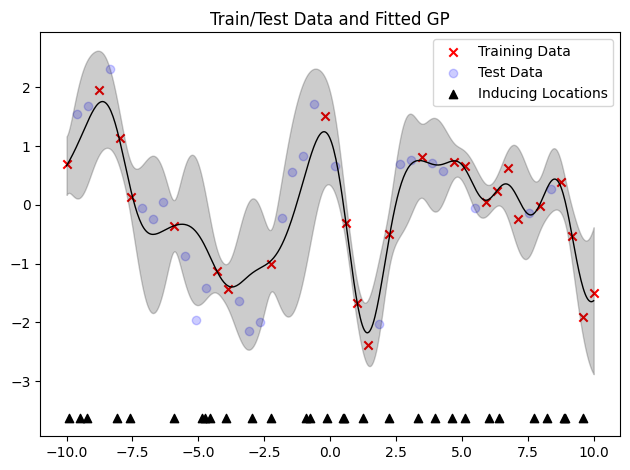

In [8]:
picked_index = 49

plot_traindata_testdata_fittedgp(train_X=list_train_X[picked_index], 
                                 train_Y=list_train_Y[picked_index], 
                                 test_X=list_test_X[picked_index], 
                                 test_Y=list_test_Y[picked_index], 
                                 gp_X=tensor_inputs4visualization, 
                                 gp_pred_mean=list_output_dist4visual[picked_index].loc.detach(), 
                                 gp_pred_std=list_output_dist4visual[picked_index].stddev.detach(), 
                                 inducing_points_X=MultiIGP.get_model(picked_index).variational_strategy.inducing_points.detach(), 
                                 n_inducing_C=config['n_inducing_input']) # NOTE: input is C not X